In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 预处理

In [3]:
path = 'F:/研习部/第二次案例分析/肠道16S测序数据'

In [4]:
databg = pd.read_csv(path+'/2054samples backgroud information.csv')
datagenus = pd.read_csv(path+'/2054samples profiling of genus.csv')
dataotu = pd.read_csv(path+'/2054samples profiling of OTUs.csv')

In [5]:
databg = databg.iloc[:,0:18]

In [6]:
databg = databg[(databg['Sampled Loci'] == 'chongqing')|(databg['Sampled Loci'] == 'quanzhou')]

In [7]:
datagenus = pd.merge(databg,datagenus,on = 'SampleID',how = 'inner')

In [8]:
dataotu = pd.merge(databg,dataotu,on = 'SampleID',how = 'inner')

## 缺失值情况

In [9]:
databg.isnull().sum()  #q缺失值情况

SampleID         0
Gender           0
Age              0
Height           6
Weight           6
BMI              0
Waistline       15
SP               0
DP               0
FBG              0
Cholesterol      0
Triglyceride     0
LDL              0
HDL              0
UA               0
Creatinine       0
eGFR             0
Sampled Loci     0
dtype: int64

In [10]:
datagenus.isnull().sum()[datagenus.isnull().sum()!=0]

Height        6
Weight        6
Waistline    15
dtype: int64

In [11]:
dataotu.isnull().sum()[dataotu.isnull().sum()!=0]

Height        6
Weight        6
Waistline    15
dtype: int64

## 特征工程
### step1 人工预先筛选

In [12]:
ndep = databg.shape[1]

In [13]:
dataotu.head()

,SampleID,Gender,Age,Height,Weight,BMI,Waistline,SP,DP,FBG,...,Otu990,Otu991,Otu992,Otu993,Otu994,Otu995,Otu996,Otu997,Otu998,Otu999
0,45.0,1,33,165.6,55.6,20.3,78.6,111,70,5.44,...,0,0,0,0,0,0,0,0,0,0
1,130.0,2,42,162.0,58.0,22.1,80.2,129,83,4.47,...,0,0,0,0,0,0,0,0,0,0
2,90041630.0,1,25,168.0,67.9,24.1,84.0,136,75,5.25,...,0,0,0,0,0,0,0,0,0,0
3,90041076.0,2,24,160.0,51.0,19.9,68.0,121,79,5.21,...,0,0,0,0,1,0,0,0,0,0
4,90041114.0,2,26,169.5,59.6,20.7,80.0,100,52,5.39,...,0,0,0,2,1,0,0,0,0,0


### 考虑计算最大信息系数MIC

In [14]:
index1 = list(range(ndep,datagenus.shape[1]))
index2 = list(range(ndep,dataotu.shape[1]))

In [15]:
from minepy import MINE
def calmic(a,b):
    m = MINE()
    m.compute_score(a,b)
    return m.mic()
MIC1 = []
MIC2 = []
for i in range(ndep,datagenus.shape[1]):
    MIC1.append(calmic(datagenus['Age'],datagenus.iloc[:,i]))
for i in range(ndep,dataotu.shape[1]):
    MIC2.append(calmic(dataotu['Age'],dataotu.iloc[:,i]))

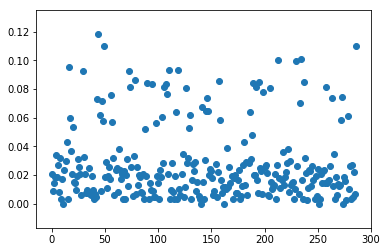

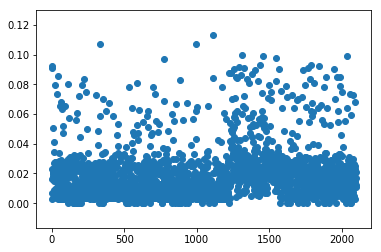

In [17]:
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(range(len(MIC1)),MIC1)
fig1.savefig('F:/研习部/第二次案例分析/ElegantNote 2.00/image/c1.png')
ax2 = fig2.add_subplot(1,1,1)
ax2.scatter(range(len(MIC2)),MIC2)
fig2.savefig('F:/研习部/第二次案例分析/ElegantNote 2.00/image/c2.png')

### 考虑计算距离相关系数dcorr

In [18]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
def distcorr(X, Y):
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor

In [19]:
dcorr1 = []
dcorr2 = []
for i in range(ndep,datagenus.shape[1]):
    dcorr1.append(distcorr(datagenus['Age'],datagenus.iloc[:,i]))
for i in range(ndep,dataotu.shape[1]):
    dcorr2.append(distcorr(dataotu['Age'],dataotu.iloc[:,i]))

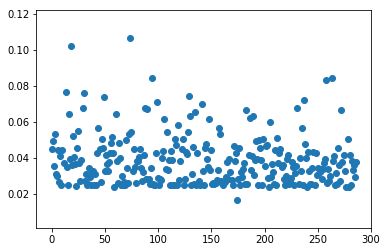

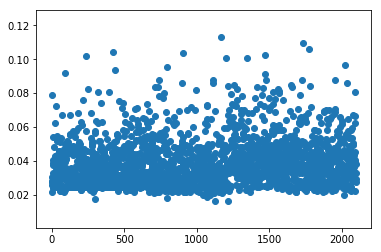

In [247]:
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(range(len(dcorr1)),dcorr1)
ax2 = fig2.add_subplot(1,1,1)
ax2.scatter(range(len(dcorr2)),dcorr2)
fig1.savefig('F:/研习部/第二次案例分析/ElegantNote 2.00/image/c3.png')
fig2.savefig('F:/研习部/第二次案例分析/ElegantNote 2.00/image/c4.png')

### 筛选 MIC是0.04，dcorr是0.06 逻辑关系是且(或 也可以尝试)

In [138]:
select_index1 = [index1[i] for i in range(len(index1)) if (MIC1[i]>0.04 and dcorr1[i]>0.06)] #or
select_index2 = [index2[i] for i in range(len(index2)) if (MIC2[i]>0.04 and dcorr2[i]>0.06)] #or

In [139]:
print(len(select_index1),len(select_index2))

18 70


### step2 xgboost包装法特征选择

In [140]:
##考虑AGE是响应变量
datagenus.head()
dataxgb = pd.merge(datagenus.iloc[:,[0,2]+select_index1],dataotu.iloc[:,[0]+select_index2],on = 'SampleID',how = 'inner')

In [141]:
dataxgb.head()

,SampleID,Age,Alistipes,Anaerostipes,Blautia,Collinsella,Desulfovibrio,Dialister,Dorea,Erysipelatoclostridium,...,Otu80,Otu81,Otu835,Otu86,Otu87,Otu91,Otu93,Otu94,Otu98,Otu99
0,45.0,33,136,27,620,0,0,0,33,122,...,0,17,0,27,54,0,0,161,0,21
1,130.0,42,9,150,315,1,0,1,1,113,...,0,0,0,150,0,1,0,0,5,28
2,90041630.0,25,3,11,122,26,2,1,82,147,...,1,39,0,11,1,92,1897,69,1,8
3,90041076.0,24,58,20,140,5,0,4,0,0,...,0,81,0,20,45,0,0,3,8,1
4,90041114.0,26,399,974,4011,689,0,0,2315,63,...,91,152,0,971,45,9,0,29,306,26


In [142]:
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
Y = dataxgb.iloc[:,1]
X = dataxgb.iloc[:,2:]

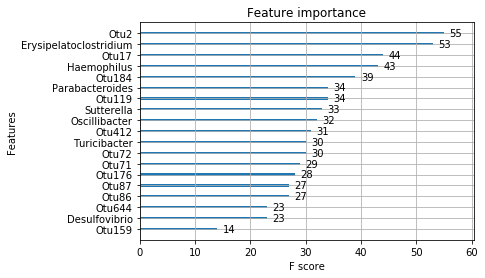

In [267]:
model = xgb.XGBRegressor()
model.fit(X.iloc[:,list(set(np.random.randint(0,X.shape[1]+1,20)))],Y)
from xgboost import plot_importance  #画出重要性图片
plot_importance(model)
fig=plt.gcf()
fig.savefig('F:/研习部/第二次案例分析/ElegantNote 2.00/image/c5.png')

In [225]:
def  rec_select(a,b): #定义递归选取变量的函数，每次删去最不重要的变量，直至删完，选取精度最好的子集
    global ans
    ans = []
    for i in range(a,b+1): #a<b
        model = xgb.XGBRegressor()
        selector = RFE(estimator=model, n_features_to_select=i) #特征选取数量从小到大
        X_choice = selector.fit_transform(X, Y) #选出新的数据集
        X_train, X_test, Y_train, Y_test = train_test_split(X_choice,Y,test_size=0.3, random_state=0)
        ans.append(np.mean(cross_val_score(model,X_choice,Y,cv = 3))) #交叉验证作为得分
        if i%10==0:
            print(i)
    index = ans.index(max(ans))
    return list(range(a,b+1))[index]
rec_select(20,88)

20
30
40
50
60
70
80


39

In [160]:
selector = RFE(estimator=model, n_features_to_select=39)
selector.fit(X, Y)
selector.support_

array([ True,  True,  True, False, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False,  True,
        True,  True, False,  True,  True, False, False, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True,  True, False, False,  True, False,  True,  True,
        True, False,  True, False,  True,  True, False, False, False,
       False,  True, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False,  True,  True,  True,
       False, False,  True, False, False,  True,  True,  True, False,
       False, False, False,  True,  True,  True,  True])

In [163]:
X.iloc[:,selector.support_].head()

,Alistipes,Anaerostipes,Blautia,Erysipelatoclostridium,Granulicatella,Salmonella,Turicibacter,Otu10,Otu102,Otu119,...,Otu67,Otu68,Otu72,Otu8,Otu80,Otu81,Otu93,Otu94,Otu98,Otu99
0,136,27,620,122,2,6,0,158,429,0,...,0,15,62,0,0,17,0,161,0,21
1,9,150,315,113,1,11,0,466,1,0,...,1,1,0,0,0,0,0,0,5,28
2,3,11,122,147,0,0,0,19,113,2,...,3,1,294,0,1,39,1897,69,1,8
3,58,20,140,0,0,3,2,639,57,0,...,5,0,80,0,0,81,0,3,8,1
4,399,974,4011,63,0,1,1,486,68,0,...,689,100,2694,0,91,152,0,29,306,26
